In [51]:
import json
import csv
import math
import os
import base64
import imageio
import cProfile
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from IPython import display
from joblib import Parallel, delayed
# from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from matplotlib.patches import Wedge
from sklearn.cluster import DBSCAN
from collections import defaultdict
from sklearn.metrics import silhouette_score
from concurrent.futures import ThreadPoolExecutor
# import matplotlib.colors as colors
# from mpl_toolkits.mplot3d import Axes3D

# Load Parameters & Data

In [52]:
# path = r"Runs/"
# folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
# latest_folder = max(folders, key=lambda f: os.path.getctime(os.path.join(path, f)))

# path = os.path.join(path, latest_folder+"/")
# print(path)
# path=r"Runs\Low Density\CRun\B31S1.0D0.0M15"
path=r"Runs\High Density\CRun\B31S1.0D0.0M15"

In [53]:
def save_param(path):
    csv_file_path=path+"/params.csv"
    # Open the CSV file
    with open(csv_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        mydict = {rows[0]:rows[1] for rows in reader}
    return mydict

def load_data(path):
    with open(path+'/particle_positions.json', 'r') as file:
        data = json.load(file)
    return data

variable_dict=save_param(path)

r=float(variable_dict["sigma"])/2.0
numParticles=int(variable_dict["numParticles"])
boxSize=float(variable_dict["boxSize"])
timestep=float(variable_dict["timestep"])
dataCompression=int(variable_dict["dataCompression"])
theta=(float(variable_dict["theta"])) 
DR=float(variable_dict["D_R"])
data = load_data(path)
particleData = np.array(data)

# Find indices and Extract particles with particle ID 1.0
indices = np.where(particleData[:, :, 0] == 1.0)
particleData1 = particleData[indices[0], indices[1]]
particleData1 = particleData1.reshape((particleData.shape[0], -1, particleData.shape[2]))
print(variable_dict)

{'comment': 'add comment', 'epsilon': '1', 'sigma': '1', 'numParticles': '625', 'boxSize': '31.3329', 'temperature': '0.00497512', 'cutoff': '1.12246', 'my_gamma': '7.05346', 'timestep': '0.0141774', 'numSteps': '1000000', 'dataCompression': '1000', 'period': '100', 'NoOfPeriods': '1000', 'theta': '15', 'R_0': '1.5', 'D_R': '0.00564276', 'D_T': '0.000705346', 'Pe': '200', 'v_0': '0.141069', 'Omega': '0.352673'}


# Minimum Image Convention Negator

In [54]:
def min_image_convention(dx, box_size):
    """
    Apply the minimum image convention to get the shortest distance between two points in a periodic box.

    Parameters:
    dx (float): The distance between the two points.
    box_size (float): The size of the periodic box.

    Returns:
    float: The shortest distance between the two points after applying the minimum image convention.
    """
    dx -= np.round(dx / box_size) * box_size
    return dx

In [55]:
marker_shapes = {
    15: 'o',   # Circle
    20: '^',   # Triangle
    25: 's',   # Square
    30: 'D',   # Diamond
    35: 'p',   # Pentagon
    40: '*',   # Star
    45: 'v',   # Inverted triangle
    60: '<',   # Left-pointing triangle
    90: '>',   # Right-pointing triangle
    }
cmap = plt.get_cmap('tab20')  # You can choose a different colormap


# Plot Energy

In [56]:
def energy_plotly_plotter(xlabel, ylabel):
    size=particleData.shape[0]
    legend_names = ["Kinetic Energy", "Potential Energy", "Total Energy"]
    colors = ['blue', 'green', 'red']
    energies=[0,0,0]

    # Calculate  kinetic, potential and total energy per particle for each time step
    energies[0] = np.average(0.5 * np.sum( particleData[:, :, 4:6] ** 2, axis=2), axis=1)
    energies[1] = particleData[:,-1, -1]  #last particle last column contains the avergae PE per particle for that timestep
    energies[2] = energies[0] + energies[1]

    # Create Plotly figure
    fig = go.Figure()
    time = [i*dataCompression*timestep for i in range(size-1)]
    for i in range(3): fig.add_trace(go.Scatter(x=time, y=energies[i], mode='lines', name=legend_names[i], line=dict(color=colors[i])))

    fig.update_layout(title="Energy Plot", xaxis_title=xlabel, yaxis_title=ylabel, width=1200, height=600)
    pio.write_html(fig, path+'/tempi.html')
    fig.show()

energy_plotly_plotter("Time", "Energy per Particle")

# Cluster Analysis

In [57]:
coordinates= particleData[-1, :, 2:4]
eps = 1.5  # The maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 2  # The number of samples in a neighborhood for a point to be considered as a core point

# Define the range of parameter values for eps and min_samples
eps_values = [0.1, 0.5, 1.0, 1.5, 2.0]  # Example values, adjust as needed
min_samples_values = [2, 3, 4, 5, 6]  # Example values, adjust as needed

In [20]:
def dbscan_params_finder(eps_values, min_samples_values, coordinates):
    best_score = -1  # Initialize best silhouette score
    best_params = {}

    # Perform grid search
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Initialize and fit DBSCAN with current parameters
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(coordinates)
            
            # Compute silhouette score
            labels = dbscan.labels_
            if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
                score = silhouette_score(coordinates, labels)

                # Update best parameters if silhouette score is higher
                if score > best_score:
                    best_score = score
                    best_params['eps'] = eps
                    best_params['min_samples'] = min_samples

    # Print the best parameters and silhouette score
    print("Best parameters:", best_params)
    print("Best silhouette score:", best_score)
    return best_params

# Specify parameters for DBSCAN
# bestParams=dbscan_params_finder(eps_values, min_samples_values, coordinates)
# eps = bestParams['eps']
# min_samples = bestParams['min_samples']

In [58]:
def frame_cluster_counter(coordinates, eps, min_samples):
    # Initialize, fit DBSCAN and Retrieve the cluster labels assigned by DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(coordinates)
    cluster_labels = dbscan.labels_

    # Initialize a dictionary to store the cluster size and the count of clusters with that size
    frame_cluster_outdata= defaultdict(int)

    # Count the number of points in each cluster
    for label in set(cluster_labels):
        # if label == -1: continue
        if label == -1: frame_cluster_outdata[1] =np.sum(cluster_labels == label)
        else: frame_cluster_outdata[np.sum(cluster_labels == label)] += 1

    return frame_cluster_outdata
frame_cluster_size_count=frame_cluster_counter(coordinates, eps, min_samples)
# Print the database listing the cluster size and the number of clusters with that size
print("Cluster Size\tNumber of Clusters\n-----------------------------------")
for cluster_size, count in sorted(frame_cluster_size_count.items()): print(f"{cluster_size}\t\t{count}")

Cluster Size	Number of Clusters
-----------------------------------
1		5
3		1
221		1
396		1


In [59]:
def spatial_clusteral_distribution(particle_data):
    accumulated_cluster_size_count = defaultdict(int)
    positions = particle_data[:, :, 2:4]
    size=positions.shape[0]

    for frame in particle_data:
        coordinates = frame[:, 2:4]
        frame_cluster_size_count=frame_cluster_counter(coordinates, eps, min_samples)

        for cluster_size, count in frame_cluster_size_count.items(): accumulated_cluster_size_count[cluster_size] += count
    return accumulated_cluster_size_count
accumulated_cluster_size_count= spatial_clusteral_distribution(particleData)
print(accumulated_cluster_size_count)

defaultdict(<class 'int'>, {625: 2, 622: 2, 1: 6937, 618: 10, 3: 439, 617: 21, 5: 138, 614: 8, 2: 1273, 612: 7, 621: 4, 578: 10, 33: 6, 586: 5, 572: 6, 32: 2, 7: 51, 583: 9, 609: 12, 8: 45, 611: 8, 4: 196, 615: 19, 608: 8, 6: 51, 613: 18, 601: 12, 606: 13, 604: 12, 610: 12, 38: 4, 566: 5, 42: 5, 563: 5, 47: 12, 607: 13, 616: 8, 587: 5, 13: 20, 11: 17, 18: 5, 573: 9, 21: 12, 569: 8, 23: 11, 28: 5, 575: 6, 605: 8, 579: 5, 30: 8, 27: 2, 568: 5, 40: 10, 567: 8, 45: 8, 557: 2, 12: 14, 562: 5, 41: 6, 44: 9, 551: 2, 51: 12, 555: 2, 54: 10, 596: 3, 603: 8, 34: 13, 29: 8, 595: 3, 597: 5, 16: 5, 599: 5, 602: 4, 14: 13, 9: 26, 10: 31, 620: 9, 598: 3, 19: 7, 36: 7, 571: 6, 548: 1, 37: 8, 565: 7, 577: 6, 559: 3, 564: 4, 25: 5, 24: 4, 590: 2, 20: 8, 15: 10, 574: 8, 570: 3, 22: 11, 17: 5, 581: 3, 585: 2, 588: 4, 589: 2, 582: 6, 591: 3, 592: 3, 619: 4, 593: 4, 600: 5, 594: 6, 580: 10, 26: 4, 576: 7, 584: 1, 31: 4, 46: 9, 49: 17, 560: 2, 561: 7, 50: 16, 48: 13, 52: 12, 55: 26, 57: 19, 528: 1, 58: 12, 5

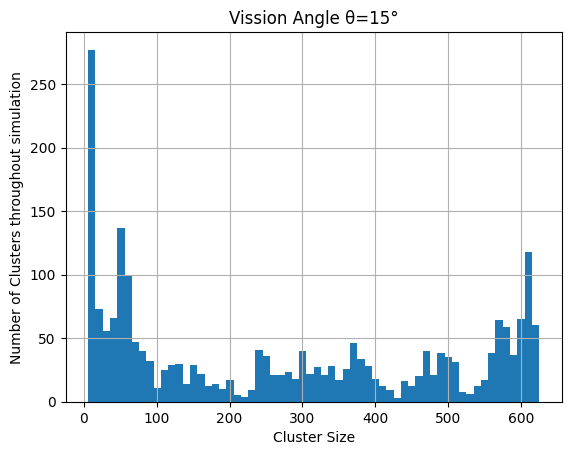

In [25]:
def plot_spatial_cluster_distrribution(particle_data, accumulated_cluster_size_count, theta, folder_path):
    # average_cluster_size_count = {cluster_size: count/size for cluster_size, count in accumulated_cluster_size_count.items()}
    bin_size = 10
    positions = particle_data[:, :, 2:4]
    num_bins = positions.shape[1] // bin_size

    # crerate a list which stores the "cluster size" n times where  n is the number of clusters of that size
    cluster_size_list = [cluster_size for cluster_size, count in accumulated_cluster_size_count.items() for _ in range(count)]
    #sort cluster_size_list
    cluster_size_list.sort()
    # remove firsdt 10% of the data
    cluster_size_list=cluster_size_list[int(len(cluster_size_list)*0.8):]
    # # plot average_cluster_size_count as a histogram
    plt.hist(cluster_size_list, bins=num_bins)
    # plt.bar(average_cluster_size_count.keys(), average_cluster_size_count.values())
    plt.xlabel('Cluster Size')
    plt.ylabel('Number of Clusters throughout simulation')
    # plt.xlim(100, 600)
    
    plt.title(f'Vission Angle \u03B8={round(theta)}\u00B0')
    plt.grid()
    plt.savefig(os.path.join(folder_path, 'spatial_clusteral_distribution.png'))
    plt.show()
    plt.close()
plot_spatial_cluster_distrribution(particleData, accumulated_cluster_size_count, theta, path)

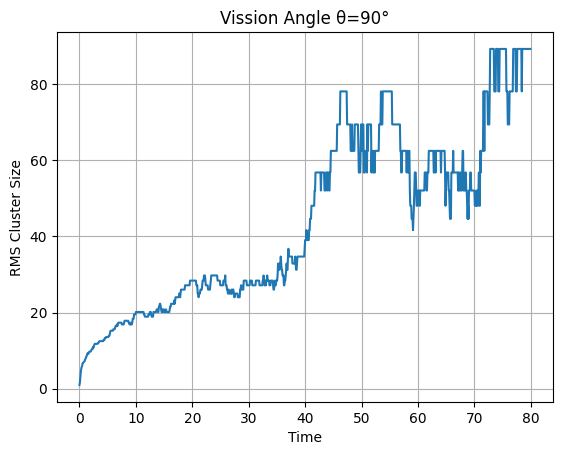

In [37]:
def temporal_clusteral_distribution(particle_data, time_step, data_compression, theta, folder_path):
    average_cluster_size = []
    rms_cluster_size = []
    positions = particle_data[:, :, 2:4]
    num_particles=positions.shape[1]

    for frame in particle_data:
        coordinates = frame[:, 2:4]
        frame_cluster_size_count=frame_cluster_counter(coordinates, eps, min_samples)
        total_no_of_clusters = np.sum(list(frame_cluster_size_count.values()))
        total_of_square_of_cluster_size=np.sum([cluster_size**2 * count for cluster_size, count in frame_cluster_size_count.items()])
        total_no_of_particles_in_cluster = np.sum([k*v for k, v in frame_cluster_size_count.items()])
        # print (total_no_of_clusters)
        # average_cluster_size.append(num_particles / total_no_of_clusters)
        # rms_cluster_size.append(np.sqrt(total_of_square_of_cluster_size / total_no_of_clusters))
        rms_cluster_size.append(total_no_of_particles_in_cluster / total_no_of_clusters)
    time = [i*data_compression*time_step*DR for i in range(particle_data.shape[0])]

    plt.plot(time, rms_cluster_size)
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('RMS Cluster Size')
    plt.title(f'Vission Angle \u03B8={round(theta)}\u00B0')
    plt.savefig(os.path.join(folder_path, 'temporal_clusteral_distribution.png'))
    plt.show()
    plt.close()
temporal_clusteral_distribution(particleData, timestep, dataCompression, theta, path)

# Final Frame Plotter

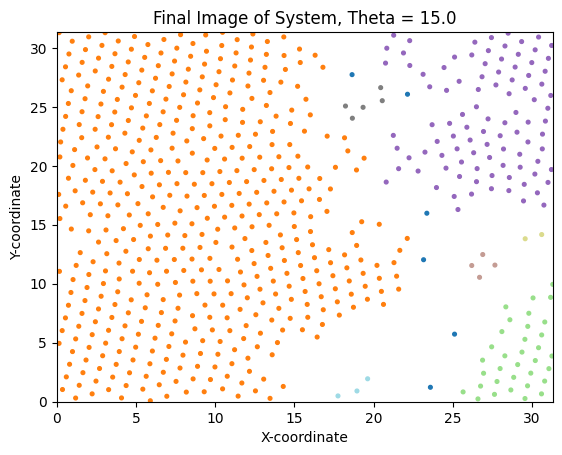

In [60]:
def FinalSysImagePlotter(particle_data, box_size, path, theta):
    # Create a figure and axis for the Plot
    fig, ax = plt.subplots()
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    positions = particle_data[-100, :, 2:4]
    
    # Initialize, fit DBSCAN and Retrieve the cluster labels assigned by DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(positions)
    cluster_labels = dbscan.labels_
    
    # plt.scatter(positions[:, 0], positions[:, 1], c=cluster_labels, marker="o", cmap='tab20', s=1*((1*r)**2))
    plt.scatter(positions[:, 0], positions[:, 1], c=cluster_labels, marker="o", cmap='tab20', s=3.14*((3*r)**2))
    # plt.scatter(positions[:, 0], positions[:, 1], c=cluster_labels, marker="o", cmap='tab20', s=3.14*((9*r)**2))
    #FIXME - Fix radius issue
    #LINK - https://stackoverflow.com/a/47403507/13882558 


    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Final Image of System, Theta = ' + str(theta))
    plt.savefig(path + "/FinalFrame.png")
    plt.show()

# Plots the final system image
FinalSysImagePlotter(particleData, boxSize, path, theta)


# Animation

In [71]:
def generate_frames_parallel(skipped_particle_data, frame, box_size, theta, path, time_step, data_compression, skip):
    plt.figure()
    plt.xlim(0, box_size)
    plt.ylim(0, box_size)
    
    frame_path = os.path.join(path, f'/frame_{frame}.png')
    positions = skipped_particle_data[frame, :, 2:4]
    time = math.floor(frame * data_compression * time_step * skip)

    # Initialize, fit DBSCAN and Retrieve the cluster labels assigned by DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(positions)
    cluster_labels = dbscan.labels_
    # plt.scatter(positions[:, 0], positions[:, 1], c=cluster_labels, marker="o", cmap='tab20', s=1*((1*r)**2))
    # plt.scatter(positions[:, 0], positions[:, 1], c=cluster_labels, marker="o", cmap='tab20', s=3.14159*((3*r)**2))
    plt.scatter(positions[:, 0], positions[:, 1], c=cluster_labels, marker="o", cmap='tab20', s=3.14159*((9*r)**2))
    plt.text(0.05, 0.95, f'Time: {time}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.title(f"\u03B8={round(theta)}\u00B0")
    frame_plt = plt
    frame_plt.savefig(frame_path)
    plt.close()

def show_gif(fname):
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')

    gif_html = f'<img src="data:image/gif;base64,{b64}" />'
    link_html = f'<a href="{fname}" target="_blank">Click here for the GIF</a>'
    # print(path+'/animation.gif')
    return display.HTML(f'{gif_html}<br>{link_html}')

def process_frame(frame):
    frame_path = os.path.join(path, f'/frame_{frame}.png')
    image = imageio.imread(frame_path)
    os.remove(frame_path)  # Delete individual PNG file
    return image
def animator(particle_data, box_size, theta, path, time_step, data_compression, skip):
    skipped_particle_data = particle_data[::skip]
    num_frames = skipped_particle_data.shape[0]
    # Use joblib for parallel execution
    Parallel(n_jobs=-1)(delayed(generate_frames_parallel)(skipped_particle_data, frame, box_size, theta, path, time_step, data_compression, skip) for frame in tqdm(range(num_frames)))

    # Combine frames into a GIF using imageio
    with imageio.get_writer(path+'/animation.gif', duration=0.1) as writer:
        # Process frames in parallel and append them to the GIF
        with ThreadPoolExecutor() as executor:
            images = list(executor.map(process_frame, range(num_frames)))
            for image in images: writer.append_data(image)
    
# animator(particleData, boxSize, theta, path, timestep, dataCompression, 2)
# show_gif(path+'/animation.gif')

In [ ]:
def generate_frames_parallel(skipped_particle_data, frame, box_size, theta, path, time_step, data_compression, skip):
    plt.figure()
    plt.xlim(0, box_size)
    plt.ylim(0, box_size)
    
    frame_path = os.path.join(path, f'/frame_{frame}.png')
    positions = skipped_particle_data[frame, :, 2:4]
    # Specify parameters for DBSCAN
    eps = 1.5  # The maximum distance between two samples for one to be considered as in the neighborhood of the other
    min_samples = 2  # The number of samples in a neighborhood for a point to be considered as a core point
    time = math.floor(frame * data_compression * time_step * skip)

    # Initialize, fit DBSCAN and Retrieve the cluster labels assigned by DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(positions)
    cluster_labels = dbscan.labels_
    
    plt.scatter(positions[:, 0], positions[:, 1], c=cluster_labels, cmap='viridis', s=3.14159 * (r ** 2))
    plt.text(0.05, 0.95, f'Time: {time}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.title(f"\u03B8={round(theta)}\u00B0")
    frame_plt = plt
    frame_plt.savefig(frame_path)
    plt.close()

def show_gif(fname):
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')

    gif_html = f'<img src="data:image/gif;base64,{b64}" />'
    link_html = f'<a href="{fname}" target="_blank">Click here for the GIF</a>'
    # print(path+'/animation.gif')
    return display.HTML(f'{gif_html}<br>{link_html}')

def animator(particle_data, box_size, theta, path, time_step, data_compression, skip):
    skipped_particle_data = particle_data[::skip]
    num_frames = skipped_particle_data.shape[0]
    # Use joblib for parallel execution
    Parallel(n_jobs=-1)(delayed(generate_frames_parallel)(skipped_particle_data, frame, box_size, theta, path, time_step, data_compression, skip) for frame in tqdm(range(num_frames)))

    # Combine frames into a GIF using imageio
    with imageio.get_writer(path+'/animation.gif', duration=0.1) as writer:
        for frame in range(num_frames):
            frame_path = os.path.join(path, f'/frame_{frame}.png')
            image = imageio.imread(frame_path)
            writer.append_data(image)
            os.remove(frame_path)
    
animator(particleData, boxSize, theta, path, timestep, dataCompression, 2)
show_gif(path+'/animation.gif')

In [ ]:
num_frames = len(particleData)
def update(frame, box_size):
    # ?Function to update each frame
    plt.figure()
    plt.xlim(0, box_size)
    plt.ylim(0, box_size)

    positions = particleData[frame, :, :]
    corner_positions=positions[[0,-1, 9, -10, 73],:]
    # Plot the particles at the given frame as circles
    try:
        for x, y, _, _, phi, _ in particleData[frame]:
            circle = plt.Circle((x, y), radius=r, linewidth=0)
            # add an if statement to change the color for the last particle in the list
            sector = Wedge((x, y), 6, np.degrees(phi) - theta, np.degrees(phi) + theta, ec='black')
            plt.gca().add_patch(sector)
            plt.gca().add_patch(circle)
        for x, y, vx, vy, phi, _ in corner_positions:
            sector = Wedge((x, y), 6, np.degrees(phi) - theta, np.degrees(phi) + theta, ec='black', fc='red')
            plt.gca().add_patch(sector)
    except:
        plt.gca().set_facecolor('black')  # Add this line to make the background black
    return plt

def generate_frames_parallel(frame, box_size):
    frame_plt = update(frame, box_size)
    frame_path = os.path.join(path, f'frame_{frame}.png')
    frame_plt.savefig(frame_path)
    plt.close()

# Use joblib for parallel execution
Parallel(n_jobs=-1)(delayed(generate_frames_parallel)(frame, boxSize) for frame in tqdm(range(num_frames)))

# ?Combine frames into a GIF using imageio
with imageio.get_writer(path+'animation.gif', duration=0.1) as writer:
    for frame in range(num_frames):
        frame_path = os.path.join(path, f'frame_{frame}.png')
        image = imageio.imread(frame_path)
        writer.append_data(image)
    

# ?Delete individual PNG files
for frame in range(num_frames):
    frame_path = os.path.join(path, f'frame_{frame}.png')
    os.remove(frame_path)

In [ ]:
phi = particleData[:1000, :, -2]
dphi = np.diff(phi, axis=0)
print (dphi.shape)
average_phi = np.average(np.abs(dphi), axis=0)
# print the position of the minimum value of average phi
print(np.argmin(average_phi))
# plot the average phi
plt.plot(average_phi)
plt.xlabel('Particles')
plt.ylabel('Average Orientation deviation')
plt.title('Average Orientation deviation vs particles')
plt.savefig(path + "/AveragePhi.png")
plt.show()

# Mean Squared Displacement

In [62]:
def MSD_particle(i, positions, box_size, size):
    n = np.zeros((size - 1, 2))
    result = []
    for j in range(math.floor(size - 1.0)):
        d = positions[j + 1:, i] - positions[:-j - 1, i]
        d -= np.round((d - n) / (box_size)) * box_size
        n = d[:-1]
        result.append(np.mean((np.linalg.norm(d, axis=1))**2))
    return result

def MSD(particle_data, box_size, time_step, data_compression, skip):
    positions = particle_data[::skip, :, 2:4]
    size=positions.shape[0]
    num_particles=positions.shape[1]
    MSDPerParticle = np.zeros((num_particles, size - 1))

    # Create a nested for-loop running through each particle and all possible gap values to create the MSD Matrix
    MSDPerParticle=Parallel(n_jobs=-1)(delayed(MSD_particle)(i, positions, box_size, size) for i in tqdm(range(num_particles)))
    MSDPerParticle = np.array(MSDPerParticle)

    # Calculate the mean and standard deviation of the MSD values
    averageMSDPerGap=[np.mean(MSDPerParticle[:, j]) for j in range(size-1)]
    stdMSDPerGap=[np.std(MSDPerParticle[:, j]) for j in range(size-1)]

    x=[i*data_compression*time_step*skip for i in range(math.floor(size-1.0))]
    y=averageMSDPerGap[:len(x)]
    dy=stdMSDPerGap[:len(x)]
    return x, y, dy
# x,y,dy=MSD(particleData1, boxSize, timestep, dataCompression, 5)

In [63]:
def plot_MSD(x,y, theta, path):
    color = cmap(theta/90)  # Use theta to get a unique color from the colormap
    theta_marker = marker_shapes.get(round(theta), 'o')  # Default to circle if theta not in the dictionary
    #fit and plot the data with an exponential function and print the fit values
    def func(v, b):
        return 4*b * np.array(v)
    # popt, pcov = curve_fit(func, x, y, p0=[100])
    # plt.plot(x, func(x, *popt), label=f'Fit:'" D_t="+str(round(popt[0], 2)), color=color)
    # print (popt)
    
    # plt.plot(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker='o', color=color, markersize=1)
    plt.scatter(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker=theta_marker, color=color, s=2)
    # plt.yscale('log')
    # plt.xscale('log')
    plt.xticks(fontsize=8)
    plt.xticks(fontsize=8)
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("MSD")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
    plt.title("Mean Squared Displacement")
    plt.tight_layout()
    # Set the figure size (adjust these values as needed)
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.savefig(path+"/MSD.png", bbox_inches = 'tight')
    # return popt and theta as a dictionary for simm plot
    # return popt

# plot_MSD(x,y, theta, path) 

# Auto-Correlation Function

In [64]:
def autoCorrelation_particle(i, positions, box_size, size):
    #for each particle i calculate min_image_convention(positions[1:size, i] - positions[0:size-1, i], b)
    direction_vector=min_image_convention(positions[1:, i] - positions[0:-1, i], box_size)
    dvnorm = np.linalg.norm(direction_vector, axis=1)
    direction_vector = direction_vector/dvnorm[:, np.newaxis]
    result = []
    # Create a nested for-loop running through each particle and gap values
    for j in range(size - 1):
        result.append(0)
        # data[k + 1][i] - data[k][i]
        d1 = direction_vector[0:-j-2]
        # data[k + j + 2][i] - data[k + j + 1][i]
        d2 = direction_vector[j:-2]

        dot_product = np.sum(d1 * d2, axis=1)
        result[j] = np.sum(dot_product) / (size - j - 1)
    return result
def autoCorrelation(particle_data, box_size, data_compression, time_step, skip):
    # Extracting x and y coordinates from the array
    positions = particle_data[::skip, :, 2:4]
    size=positions.shape[0]
    num_particles=positions.shape[1]
    # Create an empty list to store the "autoCorrelation list".
    autoCorrelationPerParticle = np.zeros((num_particles, size - 1))

    # Create a nested for-loop running through each particle and gap values
    autoCorrelationPerParticle = np.zeros((num_particles, size))
    autoCorrelationPerParticle=Parallel(n_jobs=-1)(delayed(autoCorrelation_particle)(i, positions, box_size, size) for i in tqdm(range(num_particles)))
    autoCorrelationPerParticle = np.array(autoCorrelationPerParticle)
    
    averageAutoCorrelationPerGap=[np.mean(autoCorrelationPerParticle[:, j]) for j in range(size-1)]
    stdAutoCorrelationPerGap=[np.std(autoCorrelationPerParticle[:, j]) for j in range(size-1)]

    x=[i*data_compression*time_step*skip for i in range(math.floor(size-2))]
    y=averageAutoCorrelationPerGap[:len(x)]
    dy=stdAutoCorrelationPerGap[:len(x)]
    return x, y, dy

# x, y, dy=autoCorrelation(particleData1, boxSize, dataCompression, timestep, 1)
#NOTE - Maybe plot sina*sinb+cosa*cosb

In [65]:
def plot_AutoCorrelation(x,y, dy, theta, path):
    # fit the curve with a sinusoidal decaying exponential
    def func(v, b, c, d):
        return  np.cos(2*math.pi*np.array(v)/b) * np.exp( -(np.array(v)**c)/d**c)
    try: popt, pcov = curve_fit(func, x, y, p0=[100, 1.0,100])
    except: popt=[0,0,0]

    # plt.plot(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0')
    plt.errorbar(x,y, yerr=dy, ecolor = 'lightblue', capsize=0)
    plt.plot(x, func (x, *popt), label=f'Fit:' " t_cos="+str(round(popt[0], 2)) + ", \u03B2="+str(round(popt[1], 2)) + ", t_exp="+str(round(popt[2], 2)), color='red')
    plt.xscale('log')
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("Auto-Correlation")
    plt.title(f"Auto-Correlation at \u03B8={round(theta)}\u00B0")
    # Add the fitting equation to the plot
    equation = f'Fit: cos(2\u03C0t / t_cos) * exp( -(v^\u03B2) / t_exp)'
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.legend()

    # Set the figure size (adjust these values as needed)
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.savefig(path+"/autoCorrelation.png", bbox_inches = 'tight')
    plt.show()
    plt.close()

# plot_AutoCorrelation(x,y, dy, theta, path)


# Persistence

In [66]:
def persistence_particle(i, positions, box_size, size):
    #for each particle i calculate min_image_convention(positions[1:size, i] - positions[0:size-1, i], b)
    direction_vector=min_image_convention(positions[1:, i] - positions[0:-1, i], box_size)
    dvnorm = np.linalg.norm(direction_vector, axis=1)
    direction_vector = direction_vector/dvnorm[:, np.newaxis]
    cosine_matrix = np.dot(direction_vector, direction_vector.T)
    result = []
    # Create a nested for-loop running through each particle and gap values
    for j in range(size):
        result.append(0)
        for k in range(size - j - 2):
            cosines = cosine_matrix[k,k:k+j+1]                 #Broadcasting of numpy arrays is the reason we can do the next step
            flag = np.any(cosines < 0)
            if not flag: result[j] += 1.0
        result[j] = result[j]/ int(size - j)
    return result

def persistence(particle_data, box_size, data_compression, time_step, skip):
    # Extracting x and y coordinates from the array
    positions = particle_data[::skip, :, 2:4]
    size=positions.shape[0]
    num_particles=positions.shape[1]
    
    persistencePerParticle = np.zeros((num_particles, size))
    persistencePerParticle=Parallel(n_jobs=-1)(delayed(persistence_particle)(i, positions, box_size, size) for i in tqdm(range(num_particles)))
    persistencePerParticle = np.array(persistencePerParticle)
    # Create a for loop running through persistencePerParticle[i] and finding the mean persistence
    averagePersistencePerGap=[np.mean(persistencePerParticle[:, j]) for j in range(size)]

    x = [i*data_compression*time_step*skip for i in range(size-1)]
    y = averagePersistencePerGap[:len(x)]
    
    return x, y
# x, y=persistence(particleData1, boxSize, dataCompression, timestep, 1)

In [ ]:
def persistence_particle(i, positions, box_size, size):
    #for each particle i calculate min_image_convention(positions[1:size, i] - positions[0:size-1, i], b)
    direction_vector=min_image_convention(positions[1:, i] - positions[0:-1, i], box_size)
    dvnorm = np.linalg.norm(direction_vector, axis=1)
    direction_vector = direction_vector/dvnorm[:, np.newaxis]
    cosine_matrix = np.dot(direction_vector, direction_vector.T)
    result = []
    # Create a nested for-loop running through each particle and gap values
    for j in range(size):
        result.append(0)
        for k in range(size - j - 2):
            cosines = cosine_matrix[k,k:k+j+1]                 #Broadcasting of numpy arrays is the reason we can do the next step
            flag = np.any(cosines < 0)
            if not flag: result[j] += 1.0
        result[j] = result[j]/ int(size - j)
    return result

def persistence(particle_data, box_size, data_compression, time_step, skip):
    # Extracting x and y coordinates from the array
    positions1 = particle_data[:100:, :, 2:4]
    positions2 = particle_data[100::skip, :, 2:4]
    positions = np.concatenate((positions1, positions2), axis=0)
    size=positions.shape[0]
    num_particles=positions.shape[1]
    
    persistencePerParticle = np.zeros((num_particles, size))
    persistencePerParticle=Parallel(n_jobs=-1)(delayed(persistence_particle)(i, positions, box_size, size) for i in tqdm(range(num_particles)))
    persistencePerParticle = np.array(persistencePerParticle)
    # Create a for loop running through persistencePerParticle[i] and finding the mean persistence
    averagePersistencePerGap=[np.mean(persistencePerParticle[:, j]) for j in range(size)]

    x1 = [i*data_compression*time_step for i in range(100)]
    x2 = [i*data_compression*time_step*skip for i in range(100, size-1)]
    x = x1 + x2
    y = averagePersistencePerGap[:len(x)]
    
    return x, y
# x, y=persistence(particleData1, boxSize, dataCompression, timestep, 5)

In [67]:
def plot_persistence(x, y, theta, save_path):
    color = cmap(theta/90)  # Use theta to get a unique color from the colormap
    theta_marker = marker_shapes.get(round(theta), 'o')  # Default to circle if theta not in the dictionary
    #fit and plot the data with an exponential function and print the fit values
    def func(v, a, b, c):
        # return a * np.exp(-np.array(v)/b)
        # return a * np.exp(-((np.array(v))**c)/b)
        return 1/(np.exp(((np.array(v)-c)*b))+a)
    popt, pcov = curve_fit(func, x, y, p0=[1, 100, 1])
    plt.plot(x, func(x, *popt), label=f'Fit:'" a="+str(round(popt[0], 2))+" b="+str(round(popt[1], 2))+" c="+str(round(popt[2], 2)), color=color)
    # print (popt)

    # plt.plot(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker=theta_marker, color=color, markersize=2)
    plt.scatter(x, y, label=f'Vission Angle \u03B8={round(theta)}\u00B0', marker=theta_marker, color=color, s=2)

    plt.xscale('log')
    # plt.yscale('log', base=2)
    plt.grid(True)
    plt.xlabel("Time Gap")
    plt.ylabel("Persistence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
    # Set the figure size (adjust these values as needed)
    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.savefig(save_path+"/persistence.png", bbox_inches = 'tight')
    # return popt
# plot_persistence(x, y, theta, path)

In [ ]:
def persistence(datain):
    data=datain
    size=particleData.shape[0]
    # Create an empty list to store the "Persistence list" and  average persistence per gap
    persistencePerParticle = [[0.0] * (size) for i in range(numParticles)]
    averagePersistencePerGap = [0.0] * (size)
    # Create a nested for-loop running through each particle all the possible gap values to create the Persistence Matrix; here j will be called "gap"
    for i in tqdm(range(numParticles)):
        for j in range(size):
            for k in range(size - j - 1):  # -1 because we want to avoid the last particle as there is no k+1 for it
                flag = 0
                d1x = min_image_convention(data[k + 1][i][0] - data[k][i][0], boxSize)
                d1y = min_image_convention(data[k + 1][i][1] - data[k][i][1], boxSize)
                d1norm = math.sqrt(d1x**2 + d1y**2)
                for l in range(j + 1):
                    d2x = min_image_convention(data[k + l + 1][i][0] - data[k + l][i][0], boxSize)
                    d2y = min_image_convention(data[k + l + 1][i][1] - data[k + l][i][1], boxSize)
                    d2norm = math.sqrt(d2x**2 + d2y**2)
                    if (d1x * d2x + d1y * d2y) / (d1norm * d2norm) < 0:  # if cos becomes negative
                        flag = 1
                        break
                if flag == 0:
                    persistencePerParticle[i][j] += 1.0

            persistencePerParticle[i][j] /= int(size - j)

    # Create a for loop running through persistencePerParticle[i] and finding the mean persistence
    for j in tqdm(range(size)):
        persistenceValues = []
        for i in range(numParticles):
            # Add the persistence of each particle at a given gap to the list
            persistenceValues.append(persistencePerParticle[i][j])

        # Calculate the mean  of the persistence values
        averagePersistencePerGap[j] = np.mean(persistenceValues)

    x = [i*dataCompression*timestep for i in range(size-1)]
    y = averagePersistencePerGap[:len(x)]
    
    return y, x
x, y=persistence(data)

# Multi Plotters

In [72]:
parentFolder = r"Runs\High Density\CRun"
filePaths = [f.path+"/" for f in os.scandir(parentFolder) if f.is_dir()]
MSDp=True

## Sim Animation

In [73]:
def simGif():
    for file_path in tqdm(filePaths):
        data = load_data(file_path)
        particleData = np.array(data)

        variable_dict=save_param(file_path)
        theta=(float(variable_dict["theta"]))
        boxSize=float(variable_dict["boxSize"])
        timestep=float(variable_dict["timestep"])
        dataCompression=int(variable_dict["dataCompression"])
        # FinalSysImagePlotter(particleData, boxSize, file_path, theta)
        animator(particleData, boxSize, theta, file_path, timestep, dataCompression, 1)
simGif()

100%|██████████| 1000/1000 [00:06<00:00, 150.05it/s]
C:\Users\alanb\AppData\Local\Temp\ipykernel_59696\1908730649.py:34: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

100%|██████████| 21/21 [07:45<00:00, 22.15s/it]


## Sim Autocorelation

In [ ]:
def simAutoC():
    for file_path in tqdm(filePaths):
        data = load_data(file_path)
        particleData = np.array(data)

        variable_dict=save_param(file_path)
        theta=(float(variable_dict["theta"]))
        boxSize=float(variable_dict["boxSize"])
        timestep=float(variable_dict["timestep"])
        dataCompression=int(variable_dict["dataCompression"])
        out=autoCorrelation(particleData, boxSize, dataCompression, timestep, 1)
        plot_AutoCorrelation(out[0],out[1], out[2], theta, file_path)

simAutoC()

## Sim MSD & Persistence

In [24]:
def simPlot(filePaths):
    Fit_Data = defaultdict(list)
    Plot_Data={}
    for file_path in tqdm(filePaths):
        data = load_data(file_path)
        particle_data = np.array(data)
        indices = np.where(particle_data[:, :, 0] == 1.0)
        particle_data1 = particle_data[indices[0], indices[1]]
        particle_data1 = particle_data1.reshape((particle_data.shape[0], -1, particle_data.shape[2]))

        variable_dict=save_param(file_path)
        theta=(float(variable_dict["theta"]))
        boxSize=float(variable_dict["boxSize"])
        timestep=float(variable_dict["timestep"])
        dataCompression=int(variable_dict["dataCompression"])
        #use default-dict to store the data insted of a regular dictionory
        if MSDp: Fit_Data[theta].append(np.array(MSD(particle_data1, boxSize, timestep, dataCompression, 1)))
        else: Fit_Data[theta].append(np.array(persistence(particle_data1, boxSize, dataCompression, timestep, 5)))

    for theta in Fit_Data: Plot_Data[theta] = [Fit_Data[theta][0][0], np.mean(Fit_Data[theta], axis=0)[1]]
    No_of_Runs_per_theta = {key: len(value) for key, value in Fit_Data.items()}

    return Plot_Data, Fit_Data, No_of_Runs_per_theta
Data_Dictionaries =simPlot(filePaths)
print (Data_Dictionaries[2])

100%|██████████| 48/48 [05:51<00:00,  7.32s/it]

{15.0: 3, 20.0: 3, 25.0: 3, 30.0: 3, 35.0: 3, 40.0: 3, 45.0: 3, 50.0: 3, 55.0: 3, 60.0: 3, 65.0: 3, 70.0: 3, 75.0: 3, 80.0: 3, 85.0: 3, 90.0: 3}


In [25]:
# Saving as JSON
def save_data(filename, data):
    with open(filename + '.json', 'w') as jsonfile:
        json.dump(data, jsonfile)

# Retrieve data from file
def retrieve_data(filename):
    with open(filename + '.json', 'r') as jsonfile:
        retrieved_data_json = json.load(jsonfile)
    #change the key to float
    retrieved_data_json = {float(k): v for k, v in retrieved_data_json.items()}
    return retrieved_data_json

In [39]:
l = dict(sorted({key: np.array(value) for key, value in Data_Dictionaries[0].items()}.items()))
Plot_Data = dict(sorted({key: value.tolist() for key, value in l.items()}.items()))
d = dict(sorted({key: np.array(value) for key, value in Data_Dictionaries[1].items()}.items()))
d = dict(sorted({key: value.tolist() for key, value in d.items()}.items()))

(2, 199)


In [40]:
save_data(parentFolder+'/Anal_Plot_Data', Plot_Data)
save_data(parentFolder+'/Anal_Fit_Data', d)
Plot_Data=retrieve_data(parentFolder+'/Anal_Plot_Data')
d=retrieve_data(parentFolder+'/Anal_Fit_Data')

(3, 2, 199)


In [ ]:
fit_values={}
for theta in Plot_Data:
        #For each data e store the fir vlues in a dictionary
        fit_values[theta] = []
        def func(v, a, b, c, d):
                if MSDp: fu = 4*b*np.array(v)
                else: fu = a*np.exp(-((np.array(v)/b)**c))+d
                return fu
        for entry in d[theta]:
                #check if entry is an integer type
                if isinstance(entry, int): continue
                x = entry[:][0]
                y = entry[:][1]
                try: popt, pcov = curve_fit(func, x[:], y[:])# , p0=[1, 100, 1, 0]
                except: popt = [0,0,0,0]
                fit_values[theta].append(popt[2])
        if MSDp:plot_MSD(Plot_Data[theta][0], Plot_Data[theta][1], theta, parentFolder)
        else: plot_persistence(Plot_Data[theta][0], Plot_Data[theta][1], theta, parentFolder)

# Save to Excel
df = pd.DataFrame.from_dict(fit_values)
if MSDp: df.to_excel(parentFolder+"/fit_valuesMSD.xlsx")
else: df.to_excel(parentFolder+"/fit_valuesPersistence.xlsx")

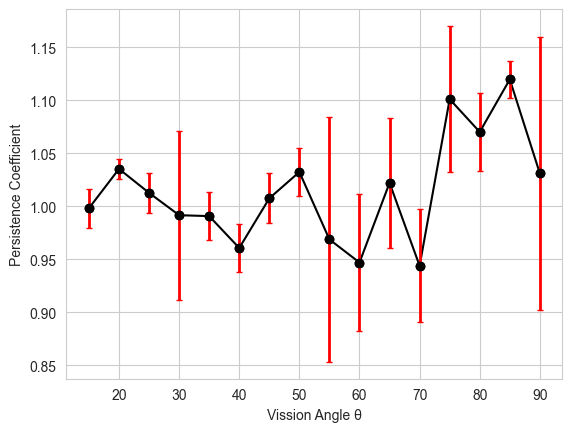

In [53]:
# Set the style of the plot
# sns.set_style("whitegrid")

# Read from Excel and save it as a dictionary
if MSDp: df = pd.read_excel(parentFolder+"/fit_valuesMSD.xlsx")
else: df = pd.read_excel(parentFolder+"/fit_valuesPersistence.xlsx")
fit_values = df.set_index('Unnamed: 0').to_dict('list')

# Plot the fit values by averaging the fit values for each theta also plot the standard deviation
x = list(fit_values.keys())
y = [np.mean(fit_values[theta]) for theta in x]
dy = [np.std(fit_values[theta]) for theta in x]
plt.plot(x, y, color='black', linestyle='-', marker='o')
plt.errorbar(x, y, yerr=dy, fmt='o', color='black', ecolor='RED', elinewidth=2, capsize=2)
plt.xlabel('Vission Angle \u03B8')
if MSDp: 
    plt.ylabel('Diffusion Coefficient')
    plt.title('Diffusion Coefficient vs Vission Angle')
    plt.savefig(parentFolder+"/MSDfit_values.png")
else:
    plt.ylabel('Persistence Coefficient')
    plt.savefig(parentFolder+"/Persistencefit_values.png")

plt.show()
# plt.close()

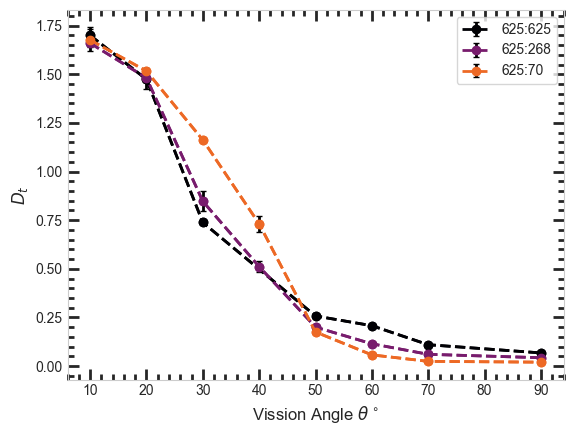

In [76]:
# Set the style of the plot
# sns.set_style("whitegrid")
gparentFolder = r"Runs\Low Density\DualRunPassive"
filePaths = [f.path+"/" for f in os.scandir(gparentFolder) if f.is_dir()]

# Define the colors for each plot
cmap = plt.get_cmap('inferno')
colors = [cmap(0/3), cmap(1/3), cmap(2/3)]
ratios=["625:625", "625:268", "625:70"]

# Loop over each file path
for file_path, color, ratio in zip(filePaths, colors, ratios):
    # Read from Excel and save it as a dictionary
    if MSDp: df = pd.read_excel(file_path+"/fit_valuesMSD.xlsx")
    else: df = pd.read_excel(file_path+"/fit_valuesPersistence.xlsx")
    fit_values = df.set_index('Unnamed: 0').to_dict('list')

    x = list(fit_values.keys())
    y = [np.mean(fit_values[theta]) for theta in x]
    dy = [np.std(fit_values[theta]) for theta in x]
    plt.plot(x, y, color=color, marker='o', linestyle='--', linewidth=2)
    plt.errorbar(x, y, yerr=dy, color=color, marker='o', linestyle='--', linewidth=2, label=ratio, ecolor='black', elinewidth=2, capsize=2)

# plt.figure(figsize=(10, 6))
plt.grid(False)
# Customize tick marks for both major and minor ticks
plt.tick_params(axis='both', which='major', direction='in', length=8, width=2, bottom=True, top=True, left=True, right=True)
plt.tick_params(axis='both', which='minor', direction='in', length=4, width=2, bottom=True, top=True, left=True, right=True)
plt.minorticks_on()

plt.xlabel('Vission Angle $\\theta^\\circ$', fontsize=12)

# plt.show()
plt.legend(fontsize=10)
if MSDp:
    plt.ylabel('$D_t$', fontsize=12)
    plt.savefig(gparentFolder+"/MSD_fit_values.png", dpi=300, bbox_inches='tight')
else:
    plt.ylabel('$t_{exp}$', fontsize=12)
    plt.savefig(gparentFolder+"/Persistence_fit_values.png", dpi=300, bbox_inches='tight')

plt.show()

# Multi Cluster Analyisis

In [ ]:
for folder in tqdm(filePaths):
    data = load_data(folder)
    particleData = np.array(data)
    variable_dict=save_param(folder)
    
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])
    timestep=float(variable_dict["timestep"])
    dataCompression=int(variable_dict["dataCompression"])
    accumulated_cluster_size_count= spatial_clusteral_distribution(particleData)
    plot_spatial_cluster_distrribution(particleData, accumulated_cluster_size_count, theta, path)
    # temporal_clusteral_distribution(particleData, timestep, dataCompression, theta, folder)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

i=0
# initialize relative_density as a 2d array
relative_density = np.zeros((len(filePaths), 25))
for folder in tqdm(filePaths):
    data = load_data(folder)
    particleData = np.array(data)
    variable_dict=save_param(folder)
    
    theta=(float(variable_dict["theta"]))
    boxSize=float(variable_dict["boxSize"])
    timestep=float(variable_dict["timestep"])
    dataCompression=int(variable_dict["dataCompression"])
    accumulated_cluster_size_count= spatial_clusteral_distribution(particleData)
    # find relative density
    relative_density[i] = [cluster_size for cluster_size, count in accumulated_cluster_size_count.items() for _ in range(count)]
# Assuming you have the following data
vision_cone = [np.linspace(15, 90, 5)]  # replace with your actual data
cluster_size = np.linspace(0, 625, 25)  # replace with your actual data
relative_density = np.random.rand(14, 100)  # replace with your actual data

X, Y = np.meshgrid(vision_cone, cluster_size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, relative_density, cmap='viridis')

ax.set_xlabel('Vision Cone')
ax.set_ylabel('Cluster Size')
ax.set_zlabel('Relative Density')

plt.show()

In [ ]:
# Step 1: Normalize and average the data
def normalize_and_average_data(accumulated_data, num_frames):
    normalized_data = {}
    for size, count in accumulated_data.items():
        normalized_data[size] = count / num_frames  # Normalize by the total number of frames
    return normalized_data

def average_normalized_data(theta_cluster_dict):
    averaged_data_dict = {}
    for theta, normalized_accumulated_cluster_size_count_list in theta_cluster_dict.items():
        averaged_data = defaultdict(float)
        for normalized_accumulated_cluster_size_count in normalized_accumulated_cluster_size_count_list:
            for size, count in normalized_accumulated_cluster_size_count.items():
                averaged_data[size] += count
        for size in averaged_data:
            averaged_data[size] /= len(normalized_accumulated_cluster_size_count_list)
        averaged_data_dict[theta] = averaged_data
    return averaged_data_dict

# Normalize and average the data for each vision cone
theta_cluster_dict = defaultdict(list)
for folder in filePaths:
    data = load_data(folder)
    particleData = np.array(data)
    theta = float(save_param(folder)["theta"])
    accumulated_cluster_size_count = spatial_clusteral_distribution(particleData)
    normalized_accumulated_cluster_size_count = normalize_and_average_data(accumulated_cluster_size_count, particleData.shape[0])
    theta_cluster_dict[theta].append(normalized_accumulated_cluster_size_count)

# Average the normalized data
theta_cluster_dict = average_normalized_data(theta_cluster_dict)

# Step 2: Create the 2D surface plot
vision_cone_angles = list(theta_cluster_dict.keys())
cluster_sizes = list(theta_cluster_dict[vision_cone_angles[0]].keys())
relative_densities = [[theta_cluster_dict[theta][size] for size in cluster_sizes] for theta in vision_cone_angles]

# Convert to 2D arrays for plotting
X, Y = np.meshgrid(vision_cone_angles, cluster_sizes)
Z = np.array(relative_densities)

# Plot the 2D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

# Set labels and title
ax.set_xlabel('Vision Cone Angle')
ax.set_ylabel('Cluster Size')
ax.set_zlabel('Relative Density')
ax.set_title('Relative Density Surface Plot')

plt.show()



In [ ]:
# Extract data for the 2D histogram
x_data = []  # Vision cone angles
y_data = []  # Cluster sizes

for folder in tqdm(filePaths):
    data = load_data(folder)
    particleData = np.array(data)
    theta = float(save_param(folder)["theta"])
    accumulated_cluster_size_count = spatial_clusteral_distribution(particleData[:, :, :])
    x_data += [theta for cluster_size, count in accumulated_cluster_size_count.items() for _ in range(count)]
    y_data += [cluster_size for cluster_size, count in accumulated_cluster_size_count.items() for _ in range(count)]

In [ ]:
# Define logarithmic bins for the y-axis and replace the first element with 0
# y_bins = np.logspace(0, np.log10(max(y_data)), num=100)
# y_bins[0]=0

# plt.hist2d(x_data, y_data, bins=[15, y_bins], cmap='viridis', norm="log")
y_bins = list(range(0, 10)) + list(range(10, 100, 10)) + list(range(100, 625, 25))
plt.hist2d(x_data, y_data, bins=[15, 40], cmap='viridis', norm="log")
#make the baackground black
plt.gca().set_facecolor('black')
plt.xlabel('Vision Cone Angle')
plt.ylabel('Cluster Size')
plt.title('2D Histogram of Cluster Sizes vs Vision Cone Angles')
# plt.yscale('log')

# Show colorbar
plt.colorbar(label='Cluster Frequency')

plt.show()

In [ ]:
# Create a new figure and axis with 3D projection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create 2D histogram with logarithmic bins and transparency
hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[15, 40], density=True)
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
x_mesh, y_mesh = np.meshgrid(x_centers, y_centers)
ax.plot_surface(x_mesh, y_mesh, hist.T, cmap='viridis', norm="log", edgecolor='none')

# Set background color to black
ax.set_facecolor('black')

# Set labels and title
ax.set_xlabel('Vision Cone Angle')
ax.set_ylabel('Cluster Size')
ax.set_zlabel('Cluster Frequency')
ax.set_title('3D Histogram of Cluster Sizes vs Vision Cone Angles')

# Show colorbar
plt.colorbar(ax.plot_surface(x_mesh, y_mesh, hist.T, cmap='viridis', norm="log"), label='Cluster Frequency')

plt.show()


In [ ]:
# Generate random data for the histogram
x = np.random.normal(0, 1, 1000000)
y = np.random.normal(0, 1, 1000000)

# Create a 2D histogram
plt.hist2d(x, y, bins=300, cmap='viridis')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Histogram')

# Add a colorbar to show the mapping of values to colors
plt.colorbar(label='Counts')

# Show the plot
plt.show()


In [ ]:
cProfile.run("persistence(data)")